In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
datasets = [
    {
        "name": "Heart Attack Prediction Dataset",
        "path": "data/heart.csv",
        "features_numerical": ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak'],
        "features_categorical": ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'],
        "target": "output",
    },

    {
        "name": "Heart Failure Prediction",
        "path": "data/heart(2).csv",
        "features_numerical": ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak' ],
        "features_categorical": ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'],
        "target": "HeartDisease",
    },

    {
        "name": "Heart Failure Prediction 2",
        "path": "data/heart_failure_clinical_records_dataset.csv",
        "features_numerical": ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time' ],
        "features_categorical": ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking',],
        "target": "DEATH_EVENT",
    },

    {
        "name": "Cardiovascular Disease Dataset",
        "path": "data/cardio_train.csv",
        "features_numerical": ['age', 'height', 'weight', 'ap_hi', 'ap_lo' ],
        "features_categorical": ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'],
        "target": "cardio",
    },

    {
        "name": "Indicators of Heart Disease",
        "path": "data/heart_2020_cleaned.csv",
        "features_numerical": ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',  ],
        "features_categorical": ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer', ],
        "target": "HeartDisease",
    },

]


In [4]:
def preprocess_dataset(dataset):
    print(f"Processing dataset: {dataset['name']}")
    df = pd.read_csv(dataset['path'])
    X_num = df[dataset["features_numerical"]]
    X_cat = df[dataset["features_categorical"]]
    y = df[dataset["target"]]

    # Encode categorical variables
    X_cat = pd.get_dummies(X_cat, drop_first=True)
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Combine features
    X = pd.concat([X_num, X_cat], axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train.iloc[:, :len(dataset["features_numerical"])] = scaler.fit_transform(X_train.iloc[:, :len(dataset["features_numerical"])])
    X_test.iloc[:, :len(dataset["features_numerical"])] = scaler.transform(X_test.iloc[:, :len(dataset["features_numerical"])])

    return X_train.to_numpy(), X_test.to_numpy(), y_train, y_test


In [5]:
def train_models(X_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=5)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

    knn.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    return knn, gb


In [26]:
# Store evaluation results
evaluation_results = []

# Main processing loop
for dataset in datasets:
    X_train, X_test, y_train, y_test = preprocess_dataset(dataset)
    knn, gb = train_models(X_train, y_train)

    # Get models probabilities
    knn_probs = knn.predict_proba(X_test)[:, 1]
    gb_probs = gb.predict_proba(X_test)[:, 1]
    fused_probs = 0.3 * knn_probs + 0.7 * gb_probs

    # Predictions
    y_pred_knn = (knn_probs >= 0.5).astype(int)
    y_pred_gb = (gb_probs >= 0.5).astype(int)
    y_pred_fused = (fused_probs >= 0.5).astype(int)

    # Get metrics
    knn_acc = accuracy_score(y_test, y_pred_knn)
    knn_roc_auc = roc_auc_score(y_test, knn_probs)

    gb_acc = accuracy_score(y_test, y_pred_gb)
    gb_roc_auc = roc_auc_score(y_test, gb_probs)
    
    fused_acc = accuracy_score(y_test, y_pred_fused)
    fused_roc_auc = roc_auc_score(y_test, fused_probs)

    print(f"{dataset['name']} - Accuracy: {fused_acc:.4f}, ROC-AUC: {fused_roc_auc:.4f}")
    evaluation_results.append({
        "dataset": dataset["name"],
        "knn_accuracy": knn_acc,
        "gb_accuracy": gb_acc,
        "fused_accuracy": fused_acc,
        "knn_roc_auc": knn_roc_auc,
        "gb_roc_auc": gb_roc_auc,
        "fused_roc_auc": fused_roc_auc,
        "fpr": roc_curve(y_test, fused_probs)[0],
        "tpr": roc_curve(y_test, fused_probs)[1],
    })


Processing dataset: Heart Attack Prediction Dataset
Heart Attack Prediction Dataset - Accuracy: 0.8022, ROC-AUC: 0.8844
Processing dataset: Heart Failure Prediction


C:\Users\AsusTUF\AppData\Local\Temp\ipykernel_27740\2880803456.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.67339636 -2.76362385 -0.47414611 -0.03805511 -1.78241911  0.39803589
 -0.25610061 -1.12828261  1.05217239 -0.03805511  0.39803589 -0.80121436
  0.39803589  0.39803589 -1.01925986 -0.47414611  0.83412689  1.16119514
 -1.23730536 -1.67339636 -0.80121436  0.94314964 -1.23730536 -1.12828261
  0.83412689  0.39803589 -1.12828261  1.48826338  1.37924064  0.07096764
  0.50705864  0.28901314  0.17999039  1.70630888  0.72510414 -0.25610061
  0.61608139  0.28901314  0.28901314  2.14239988  1.16119514 -2.10948735
  0.39803589 -0.36512336  1.05217239  0.39803589  0.17999039 -1.34632811
 -0.80121436  1.37924064  0.07096764  0.72510414 -1.45535086 -1.89144186
  0.61608139  1.16119514  1.05217239 -1.23730536 -0.14707786  1.37924064
 -1.23730536 -0.14707786 -0.25610061 -0.03805511 -1.01925986 -2.10948735
 -0.58316

Heart Failure Prediction - Accuracy: 0.8659, ROC-AUC: 0.9390
Processing dataset: Heart Failure Prediction 2
Heart Failure Prediction 2 - Accuracy: 0.7111, ROC-AUC: 0.8404
Processing dataset: Cardiovascular Disease Dataset


C:\Users\AsusTUF\AppData\Local\Temp\ipykernel_27740\2880803456.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7.23085196e-03 -4.48525189e-01 -5.29716883e-01  3.02768617e-01
 -4.61515860e-01  7.23085196e-03  7.23085196e-03  7.23085196e-03
 -5.03735541e-01  7.23085196e-03 -5.00487873e-01 -5.97917906e-01
 -4.37699630e-01  7.23085196e-03  7.23085196e-03  1.93430470e-01
 -4.87497202e-01  2.81117499e-01 -6.63829504e-02  2.17246700e-01
 -2.76398798e-01 -5.71936564e-01  1.56069859e+00 -5.31881995e-01
 -5.22138991e-01  7.23085196e-03  1.05297987e+00 -4.98322761e-01
 -5.53533113e-01 -2.21188447e-01 -4.83166978e-01 -1.95207104e-01
 -1.05354963e-01  7.65144306e-02 -3.59470721e-03  2.25245182e+00
 -2.35261673e-01 -3.72746275e-01 -5.51368001e-01 -5.58945893e-01
 -2.23353558e-01  7.23085196e-03 -5.12395988e-01 -5.53533113e-01
 -5.53533113e-01 -4.95075093e-01  9.13330154e-01 -4.64763528e-01
 -1.89794325e-01 -5.48120333e-01

Cardiovascular Disease Dataset - Accuracy: 0.7332, ROC-AUC: 0.7951
Processing dataset: Indicators of Heart Disease
Indicators of Heart Disease - Accuracy: 0.9147, ROC-AUC: 0.8261


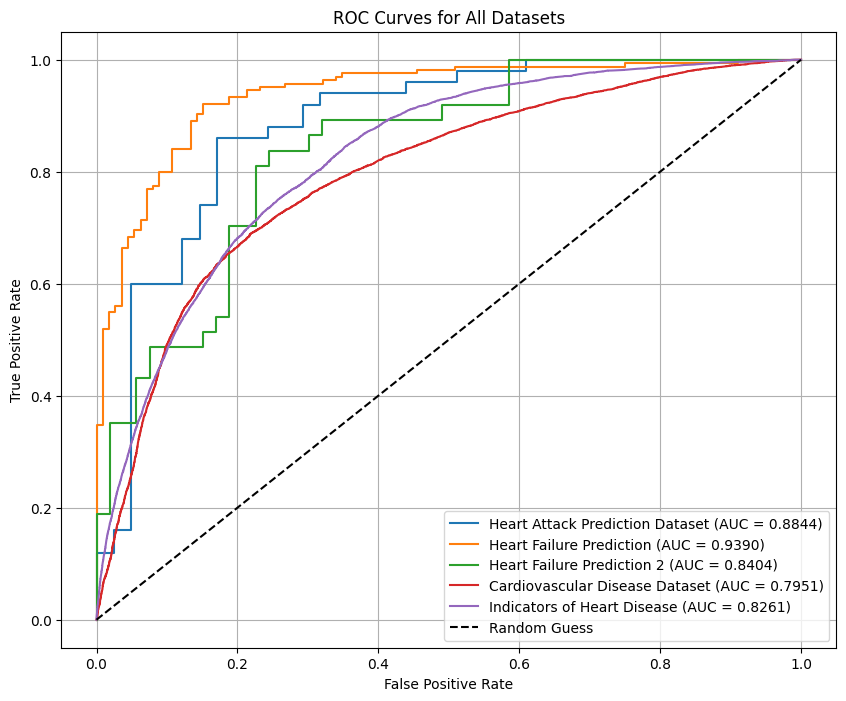

In [27]:
plt.figure(figsize=(10, 8))
for result in evaluation_results:
    plt.plot(result["fpr"], result["tpr"], label=f'{result["dataset"]} (AUC = {result["fused_roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves for All Datasets")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\AsusTUF\AppData\Local\Temp\ipykernel_27740\717902342.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="dataset", y="fused_accuracy", data=accuracy_data, palette="viridis")


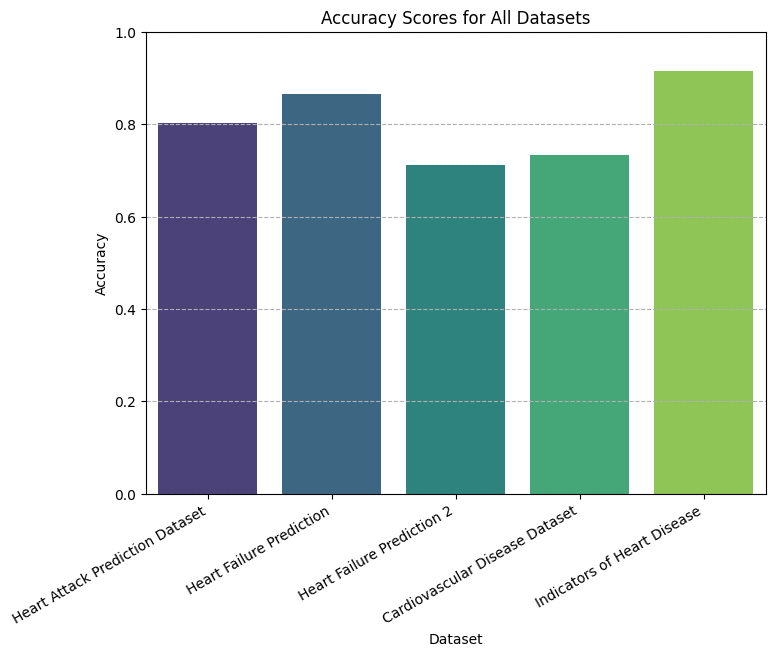

In [28]:
plt.figure(figsize=(8, 6))
accuracy_data = pd.DataFrame(evaluation_results)
sns.barplot(x="dataset", y="fused_accuracy", data=accuracy_data, palette="viridis")
plt.ylim(0, 1)
plt.title("Accuracy Scores for All Datasets")
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.xticks(rotation=30, ha="right")
plt.grid(axis='y', linestyle='--')
plt.show()


In [29]:
df_evaluation_results = pd.DataFrame(evaluation_results)
df_evaluation_results

,dataset,knn_accuracy,gb_accuracy,fused_accuracy,knn_roc_auc,gb_roc_auc,fused_roc_auc,fpr,tpr
0,Heart Attack Prediction Dataset,0.846154,0.780220,0.802198,0.868049,0.872683,0.884390,"[0.0, 0.0, 0.0, 0.024390243902439025, 0.024390...","[0.0, 0.02, 0.12, 0.12, 0.16, 0.16, 0.6, 0.6, ..."
1,Heart Failure Prediction,0.851449,0.873188,0.865942,0.912946,0.931021,0.938970,"[0.0, 0.0, 0.0, 0.008928571428571428, 0.008928...","[0.0, 0.006097560975609756, 0.3475609756097561..."
2,Heart Failure Prediction 2,0.722222,0.700000,0.711111,0.808771,0.848547,0.840388,"[0.0, 0.0, 0.0, 0.018867924528301886, 0.018867...","[0.0, 0.02702702702702703, 0.1891891891891892,..."
3,Cardiovascular Disease Dataset,0.648810,0.737667,0.733190,0.690862,0.804699,0.795149,"[0.0, 9.559315553006405e-05, 9.559315553006405...","[0.0, 0.0, 0.000189771325552709, 0.00018977132..."
4,Indicators of Heart Disease,0.906336,0.914779,0.914685,0.695779,0.835715,0.826126,"[0.0, 0.0, 0.0, 1.1409143287430547e-05, 1.1409...","[0.0, 0.00012062726176115802, 0.00024125452352..."


In [30]:
df_evaluation_results.describe()

,knn_accuracy,gb_accuracy,fused_accuracy,knn_roc_auc,gb_roc_auc,fused_roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.794994,0.801171,0.805425,0.795281,0.858533,0.857004
std,0.105909,0.090555,0.086203,0.100158,0.047364,0.055956
min,0.648810,0.700000,0.711111,0.690862,0.804699,0.795149
25%,0.722222,0.737667,0.733190,0.695779,0.835715,0.826126
50%,0.846154,0.780220,0.802198,0.808771,0.848547,0.840388
75%,0.851449,0.873188,0.865942,0.868049,0.872683,0.884390
max,0.906336,0.914779,0.914685,0.912946,0.931021,0.938970
